2025-05-19 23:55:55,746 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:65 - DatabaseManager initialized for DB: 'C:\Users\amber\Documents\Mitchell\school\2025\DASC500\DASC500\src\DASC500\../..\data/DASC501/homework6\DataViz501.db'
2025-05-19 23:55:55,757 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:101 - Connecting to database: 'C:\Users\amber\Documents\Mitchell\school\2025\DASC500\DASC500\src\DASC500\../..\data/DASC501/homework6\DataViz501.db'...
2025-05-19 23:55:55,757 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:105 - Database connection established successfully.
2025-05-19 23:55:55,791 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 6718 records.


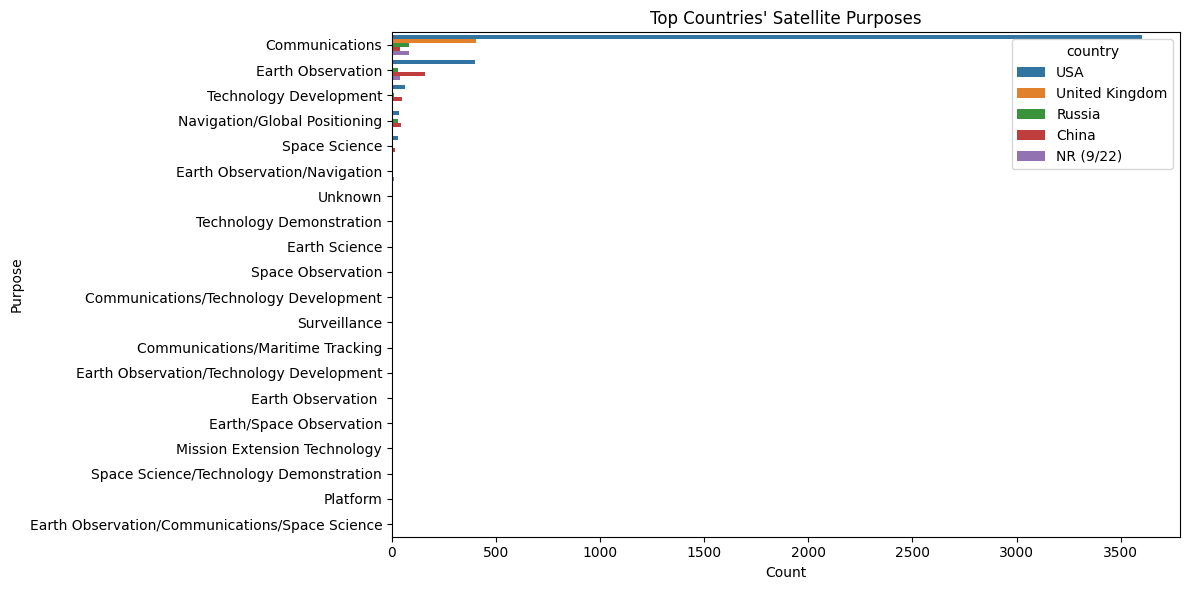

2025-05-19 23:55:57,282 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 1925 records.


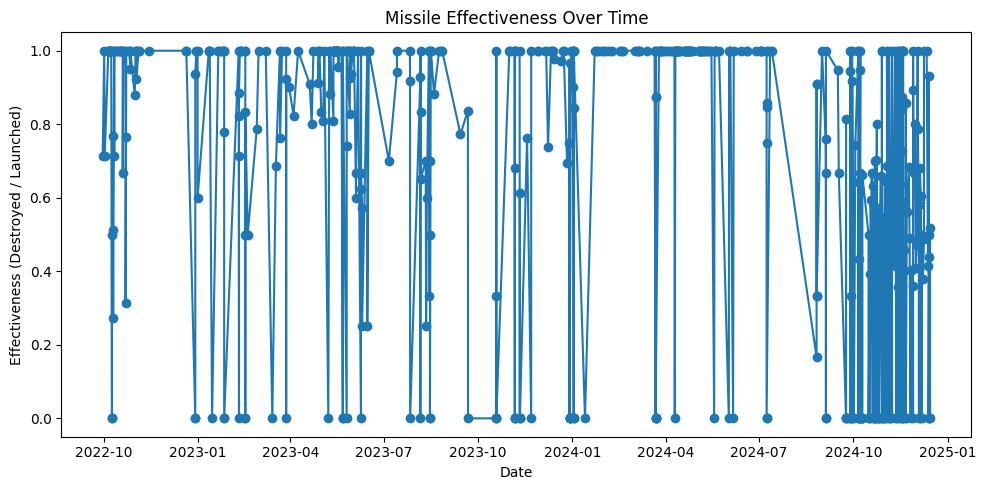

2025-05-19 23:55:58,096 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 128 records.
[None 'Astrakhan oblast' 'Balaklava, Crimea' 'Belarus'
 'Belgorod and Tokmak' 'Belgorod oblast' 'Belgorod oblast and Crimea'
 'Belgorod oblast and Donetsk oblast' 'Belgorod oblast and Kursk oblast'
 'Belgorod oblast and Sea of Azov' 'Belgorod oblast and Voronezh oblast'
 'Black Sea' 'Black Sea and Sea of Azov' 'Black Sea, Feodosia'
 'Black Sea, Yalta' 'Bryansk oblast' 'Bryansk oblast and Krasnodar Krai'
 'Bryansk oblast and Oryol oblast'
 'Bryansk oblast and eastern coast of Sea of Azov'
 'Bryansk oblast, Seshcha']


2025-05-19 23:56:06,776 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 6718 records.


2025-05-19 23:56:07,955 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 776 records.
2025-05-19 23:56:13,197 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 121 records.


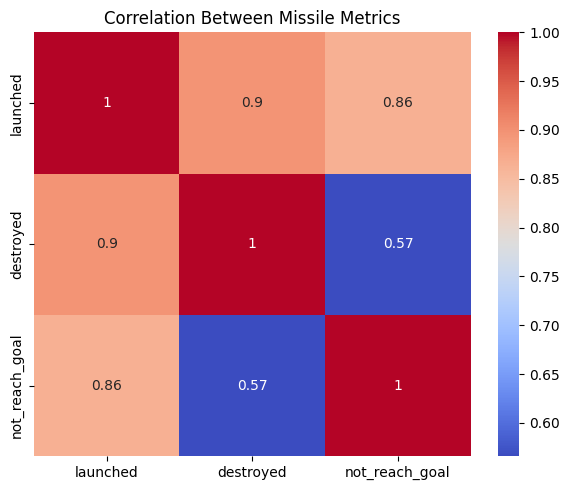

2025-05-19 23:56:15,327 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 6718 records.


2025-05-19 23:56:18,573 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 6718 records.


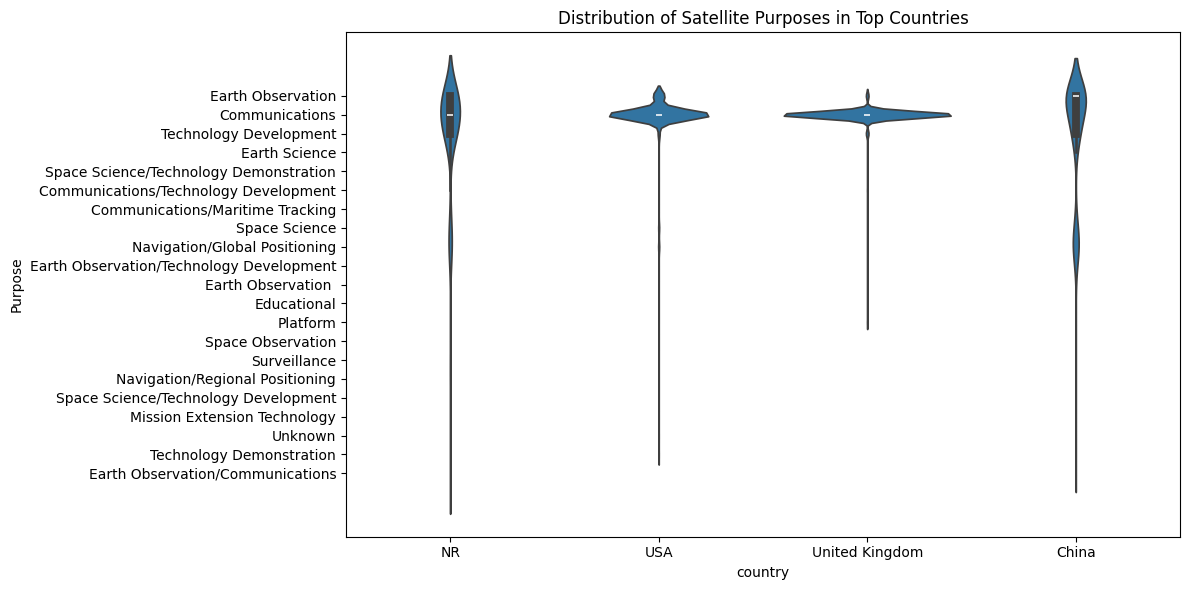

2025-05-19 23:56:20,997 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:118 - Committing final changes (if any) and closing connection...
2025-05-19 23:56:20,997 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:122 - Database connection to 'C:\Users\amber\Documents\Mitchell\school\2025\DASC500\DASC500\src\DASC500\../..\data/DASC501/homework6\DataViz501.db' closed.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from DASC500.classes.DatabaseManager import DatabaseManager
from DASC500.utilities.get_top_level_module import get_top_level_module_path
import os

FOLDER = os.path.join(get_top_level_module_path(), "../..")
INPUT_FILE = os.path.join(FOLDER, 'data/DASC501/homework6', "DataViz501.db")
OUTPUT_FOLDER = os.path.join(FOLDER, 'outputs/DASC501/homework6')

# Initialize database connection
db = DatabaseManager(INPUT_FILE)
db.connect()

# --- Plot 1: Seaborn Countplot - Satellite Purpose by Country ---
query_sat = """
SELECT "Country/Org of UN Registry" AS country, Purpose
FROM "UCS-Satellite-Database-1-1-2023"
WHERE Purpose IS NOT NULL AND country IS NOT NULL
"""
df_sat = db.execute_select_query(query_sat)

# Remove junk values like "NR"
df_sat = df_sat[~df_sat['country'].str.upper().isin(['NR', 'NR (4/22)', 'N/A', 'UNKNOWN'])]

# Focus on top 5 countries with most satellites
top_countries = df_sat['country'].value_counts().head(5).index
df_filtered = df_sat[df_sat['country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, y="Purpose", hue="country", order=df_filtered['Purpose'].value_counts().index)
plt.title("Top Countries' Satellite Purposes")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "plot1_satellite_purposes.png"))
plt.show()

# --- Plot 2: Matplotlib Line Plot - Missile Effectiveness Over Time ---
query_missiles = """
SELECT time_start, launched, destroyed
FROM missile_attacks_daily
WHERE launched > 0
"""
df_missiles = db.execute_select_query(query_missiles)
df_missiles['time_start'] = pd.to_datetime(df_missiles['time_start'], errors='coerce')
df_missiles = df_missiles.dropna(subset=['time_start'])
df_missiles['effectiveness'] = df_missiles['destroyed'] / df_missiles['launched']
df_missiles = df_missiles.sort_values('time_start')

plt.figure(figsize=(10, 5))
plt.plot(df_missiles['time_start'], df_missiles['effectiveness'], marker='o')
plt.title("Missile Effectiveness Over Time")
plt.ylabel("Effectiveness (Destroyed / Launched)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "plot2_missile_effectiveness.png"))
plt.show()

# --- Plot 3: Plotly Choropleth - Total Missiles Launched by Country ---
# Load raw launch_place and totals
query = """
SELECT launch_place, SUM(launched) AS total_launched
FROM missile_attacks_daily
GROUP BY launch_place
"""
df_launch = db.execute_select_query(query)

# Preview to see what values look like
print(df_launch['launch_place'].unique()[:20])  # helps tailor mappings

# Create a mapping based on real values
place_country_map = {
    'Russia': 'Russia',
    'Ukraine': 'Ukraine',
    'Crimea': 'Russia',
    'Donetsk': 'Ukraine',
    'Belarus': 'Belarus',
    'Occupied Territories': 'Russia',
    'Black Sea': 'Russia',
    # Add based on printout if needed
}

def map_launch_to_country(val):
    if not isinstance(val, str):
        return None
    for k, v in place_country_map.items():
        if k.lower() in val.lower():
            return v
    return None

df_launch['country'] = df_launch['launch_place'].apply(map_launch_to_country)
df_launch = df_launch.dropna(subset=['country'])

fig3 = px.choropleth(
    df_launch,
    locations='country',
    locationmode='country names',
    color='total_launched',
    title="Missile Launches by Country (Manual Mapping)",
    color_continuous_scale='Reds',
)

fig3.update_geos(
    visible=True,
    resolution=50,
    scope='europe',
    center=dict(lat=50, lon=35),
    projection_scale=5
)
fig3.update_layout(margin=dict(l=0, r=0, t=30, b=0))
fig3.write_image(os.path.join(OUTPUT_FOLDER, "plot3_fixed_choropleth.png"))
fig3.show()

# --- Plot 4: Plotly Sankey Diagram - Satellite Users to Purposes ---
query_links = """
SELECT Users, Purpose
FROM "UCS-Satellite-Database-1-1-2023"
WHERE Users IS NOT NULL AND Purpose IS NOT NULL
"""
df_links = db.execute_select_query(query_links)
df_links = df_links[df_links['Users'].str.contains(';') == False]
df_links = df_links[df_links['Purpose'].str.contains(';') == False]
df_links = df_links.head(100)

labels = pd.unique(df_links[['Users', 'Purpose']].values.ravel())
label_to_index = {label: i for i, label in enumerate(labels)}
df_links['source'] = df_links['Users'].map(label_to_index)
df_links['target'] = df_links['Purpose'].map(label_to_index)

fig2 = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=df_links['source'], target=df_links['target'], value=[1]*len(df_links))
)])
fig2.update_layout(title="Satellite Users → Purposes")
fig2.write_image(os.path.join(OUTPUT_FOLDER, "plot4_sankey.png"))
fig2.show()

#--- Optional Plot 5: Folium Map - Military Base Locations ---
query_bases = """
SELECT "Geo Point", "Site Name", COUNTRY
FROM "military-bases"
WHERE "Geo Point" IS NOT NULL
"""
df_bases = db.execute_select_query(query_bases)

# Parse lat/lon robustly
def parse_lat_lon(geo_point):
    if isinstance(geo_point, str):
        try:
            coords = geo_point.split(',')
            lat = float(coords[0].strip())
            lon = float(coords[1].strip())
            return pd.Series([lat, lon])
        except Exception:
            return pd.Series([None, None])
    return pd.Series([None, None])

df_bases[['lat', 'lon']] = df_bases['Geo Point'].apply(parse_lat_lon)

# Drop rows with bad coordinates
df_bases = df_bases.dropna(subset=['lat', 'lon'])

# Final check
if df_bases.empty:
    raise ValueError("No valid geo points for Folium map.")

map_center = [df_bases['lat'].mean(), df_bases['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

for _, row in df_bases.iterrows():
    folium.Marker([row['lat'], row['lon']],
                  popup=f"{row['Site Name']} ({row['COUNTRY']})").add_to(m)

m.save(os.path.join(OUTPUT_FOLDER, "plot5_fixed_military_bases_map.html"))


# --- Correlation Heatmap of Missile Metrics ---
query_corr = """
SELECT launched, destroyed, not_reach_goal
FROM missile_attacks_daily
WHERE launched IS NOT NULL AND destroyed IS NOT NULL AND not_reach_goal IS NOT NULL
"""
df_corr = db.execute_select_query(query_corr)

plt.figure(figsize=(6, 5))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Missile Metrics")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "plot6_missile_correlation_heatmap.png"))
plt.show()

query_sunburst = """
SELECT "Operator/Owner" AS owner, Users
FROM "UCS-Satellite-Database-1-1-2023"
WHERE Users IS NOT NULL AND "Operator/Owner" IS NOT NULL
"""
df_sunburst = db.execute_select_query(query_sunburst)
df_sunburst = df_sunburst[df_sunburst['Users'].str.contains(';') == False]
df_sunburst = df_sunburst[df_sunburst['owner'].str.contains(';') == False]
df_sunburst = df_sunburst.dropna().head(150)

fig = px.sunburst(df_sunburst, path=['owner', 'Users'], title='Satellite Operators and Their User Types')
fig.write_image(os.path.join(OUTPUT_FOLDER, "plot7_satellite_sunburst.png"))
fig.show()

query_violin = """
SELECT "Country/Org of UN Registry" AS country, Purpose
FROM "UCS-Satellite-Database-1-1-2023"
WHERE Purpose IS NOT NULL AND country IS NOT NULL
"""
df_violin = db.execute_select_query(query_violin)
top_countries_violin = df_violin['country'].value_counts().head(4).index
df_violin = df_violin[df_violin['country'].isin(top_countries_violin)]

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_violin, x="country", y="Purpose")
plt.title("Distribution of Satellite Purposes in Top Countries")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "plot8_violin_satellite_purposes.png"))
plt.show()


# --- Cleanup ---
db.close()
